# Correlation inference for compositional data through ``scope``
* What we are interested is the correlation matrix $\bm{\Sigma}$ (assumed to be sparse) of $\bm{y}\in\mathbb{R}^p$ which is latent.
* The observable data is its compositional version $\bm{x}$ with $$x_j=\frac{y_j}{\sum_j y_j}.$$
* This example shows how to estimate $\bm{\Sigma}$ based on the samples $\{x^{(i)}\}_{i=1}^n$ with ``scope``.
* To recover the true sparse correlation structure, we minimize the following loss function proposed by [Fang et al.](https://academic.oup.com/bioinformatics/article/31/19/3172/211784)$$L(\Sigma)=\frac{1}{2}\|F_0(\Sigma-S)F_0\|_V^2$$ where $F_0=I_p-p^{-1}1_p1_p^{\top}$ and $S$ is the sample covariance of $\log x$. Meanwhile, to keep symmetry of $\Sigma$, we denote the parameter of this problem as the lower triangle entries of $\Sigma$ and we encourage sparsity of this parameter using ``scope``. If the resulted estimator is positive definite, we directly output it as the final estimator, otherwise we find a closest positive definite matrix as the final estimator as suggested in [Fang et al.](https://academic.oup.com/bioinformatics/article/31/19/3172/211784).

In [1]:
import numpy as np
np.random.seed(123)
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from scope import ScopeSolver

import warnings
warnings.filterwarnings('ignore')

In [2]:
n, p = 500, 50
mu = np.zeros(p)
Sigma = np.zeros((p, p))
for i in range(p):
    for j in range(p):
        if i == j:
            Sigma[i, j] = 1
        elif np.abs(i - j) <= 4:
            Sigma[i, j] = 0.6 ** np.abs(i - j)
Y_log = np.random.multivariate_normal(mu, Sigma, size=n)
Y = np.exp(Y_log)
X = Y / np.sum(Y, axis=1).reshape(-1, 1)
k = int(len((np.nonzero(Sigma)[0]) - p) / 2)  # true sparsity

In [3]:
def ccscope(X, k):
    n, p = X.shape
    S = jnp.cov(jnp.log(X), rowvar=False)
    F = jnp.eye(p) - jnp.ones((p, 1)) @ jnp.ones((1, p)) / p
    V = jnp.linalg.inv(F @ jnp.diag(jnp.diag(S)) @ F.T)

    def arr_to_cov(arr):
        arr = jnp.array(arr)
        roots = np.poly1d([1, 1, - 2 * len(arr)]).r  # p(p-1)/2 = len(arr)
        dim_cov = int(roots[roots > 0])
        cov = jnp.zeros((dim_cov, dim_cov))
        idx = np.tril_indices(dim_cov, k=0, m=dim_cov)
        cov = cov.at[idx].set(arr)
        cov = cov + jnp.tril(cov, -1).T
        return cov
    
    def custom_objective(params):
        cov = arr_to_cov(params)
        loss = jnp.trace(F @ (cov - S) @ F.T @ V @ F @ (cov - S) @ F.T)
        return loss
    
    solver = ScopeSolver(int(p * (p+1) / 2), k)
    params = solver.solve(custom_objective)

    return arr_to_cov(params)

In [4]:
Sigma_hat = ccscope(X=X, k=k)  # assume the true sparsity is known
print('If estimator is positive definite: ', (np.linalg.eigvals(Sigma_hat) > 0).all())

If estimator is positive definite:  True


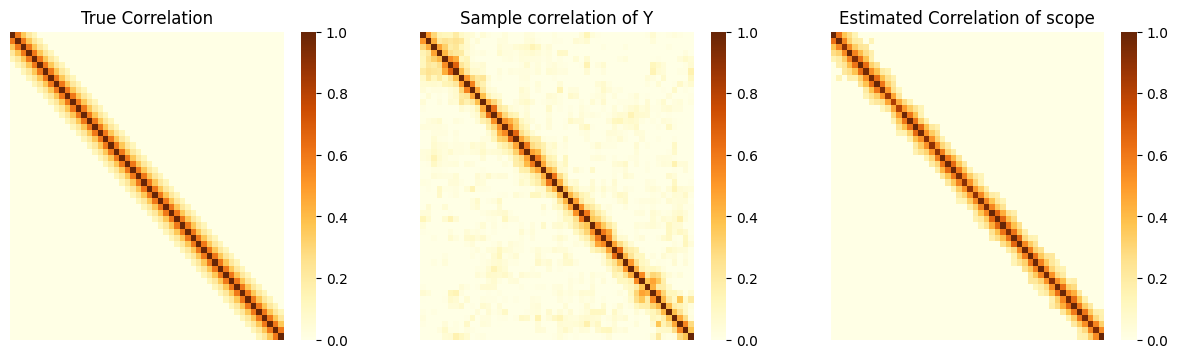

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

sns.heatmap(Sigma, vmin=0, vmax=1, cmap='YlOrBr', ax=ax1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('True Correlation')

sns.heatmap(np.corrcoef(Y, rowvar=False), vmin=0, vmax=1, cmap='YlOrBr', ax=ax2)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Sample correlation of Y')

sns.heatmap(Sigma_hat, vmin=0, vmax=1, cmap='YlOrBr', ax=ax3)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('Estimated Correlation of scope')

plt.show()

In [6]:
Sigma_hat

DeviceArray([[1.0611925 , 0.6271886 , 0.36419386, ..., 0.        ,
              0.        , 0.        ],
             [0.6271886 , 0.9882463 , 0.5593988 , ..., 0.        ,
              0.        , 0.        ],
             [0.36419386, 0.5593988 , 0.9103935 , ..., 0.        ,
              0.        , 0.        ],
             ...,
             [0.        , 0.        , 0.        , ..., 0.9251217 ,
              0.5616015 , 0.32575828],
             [0.        , 0.        , 0.        , ..., 0.5616015 ,
              0.94260705, 0.5408449 ],
             [0.        , 0.        , 0.        , ..., 0.32575828,
              0.5408449 , 1.0079799 ]], dtype=float32)